<a href="https://colab.research.google.com/github/shu65/diffusion-model-book/blob/main/diffusion_model_book_2_3_ddpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm import tqdm_notebook as tqdm
import torch

device="cpu"

In [ ]:
n_samples = int(1e6)
sigma = 0.01

dist0 = torch.distributions.MultivariateNormal(torch.tensor([-2, -2], dtype=torch.float).to(device), sigma*torch.eye(2, dtype=torch.float).to(device))
samples0 = dist0.sample(torch.Size([n_samples//2]))
    
dist1 = torch.distributions.MultivariateNormal(torch.tensor([2, 2], dtype=torch.float).to(device), sigma*torch.eye(2, dtype=torch.float).to(device))
samples1 = dist1.sample(torch.Size([n_samples//2]))
samples = torch.vstack((samples0, samples1))

mean = torch.mean(samples, dim=0)
std = torch.std(samples, dim=0)

normalized_samples = (samples - mean[None, :])/std[None, :]

dataset = torch.utils.data.TensorDataset((normalized_samples))

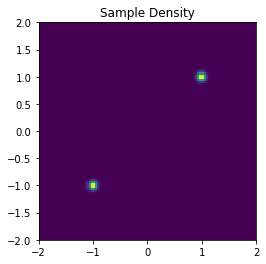

In [ ]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

plot_samples = normalized_samples.cpu().numpy()

plt.hist2d(plot_samples[:,0], plot_samples[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('Sample Density')
plt.show()

In [ ]:
beta_start = 1e-4
beta_end = 0.02
T = 1000

betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32)
alphas = 1. - betas
alpha_bars = np.cumprod(alphas, axis=0)
#alpha_bars_prev = np.append(1., alpha_bars[:-1])
beta_bars = 1. - alpha_bars

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self, n_channels=2):
    super(Model, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(n_channels + 1, 2*n_channels),
        nn.ELU(),
        nn.Linear(2*n_channels, 16*n_channels),
        nn.ELU(),
        nn.Linear(16*n_channels, 2*n_channels),
        nn.ELU(),
        nn.Linear(2*n_channels, n_channels),
    )

  def forward(self, x, t):
    h = torch.hstack((x, t[:, None]))
    y = self.model(h)
    return y/sigma

In [ ]:
import torch

batch_size = 512
n_steps = 100000

dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0)
dataloader_iter = iter(dataloader)

model = Model().to(device)

optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=n_steps)
loss_func = torch.nn.MSELoss(reduction="none")

for i in range(n_steps):
  try:
    x0 = next(dataloader_iter)[0]
  except StopIteration:
    dataloader_iter = iter(dataloader)
    x0 = next(dataloader_iter)[0]
  x0 = x0.to(device)

  optimizer.zero_grad()

  noise = torch.randn_like(x0)
  t = torch.randint(0, len(x0), (x0.shape[0],), device=device)
  x = torch.sqrt(alpha_bars[t])[:, None] * x0 + torch.sqrt(beta_bars[t])[:, None] * noise
  noise_pred = model(x, t)
  w = 1.0
  losses = w * loss_func(noise_pred, noise)
  loss = losses.mean()

  loss.backward()
  optimizer.step()
  lr_scheduler.step()
  if (i % 1000) == 0:
    print(f"{i} steps loss:{loss}")


0 steps loss:23875.875
1000 steps loss:132.5301513671875
2000 steps loss:9.484153747558594
3000 steps loss:3.648064613342285
4000 steps loss:1.5667074918746948
5000 steps loss:1.4025388956069946
6000 steps loss:0.935090959072113
7000 steps loss:0.8864482641220093
8000 steps loss:0.9047664403915405
9000 steps loss:0.8091503977775574
10000 steps loss:0.9268974661827087
11000 steps loss:0.7563892006874084
12000 steps loss:1.9006308317184448
13000 steps loss:1.8024271726608276
14000 steps loss:0.8339951038360596
15000 steps loss:0.6597978472709656
16000 steps loss:0.6305830478668213
17000 steps loss:0.6409674882888794
18000 steps loss:1.0973621606826782
19000 steps loss:0.8876875042915344
20000 steps loss:0.5260683298110962
21000 steps loss:0.688625156879425
22000 steps loss:0.541122317314148
23000 steps loss:0.5458923578262329
24000 steps loss:0.5823242664337158
25000 steps loss:0.5624390840530396
26000 steps loss:0.5464179515838623
27000 steps loss:0.5349265933036804
28000 steps loss:0.5

In [ ]:
def ddpm_sample(n_samples, model, alphas, betas, beta_bars):
    xt = torch.randn(n_samples, 2)
    T = len(alphas)
    for t in range(T -1, -1, -1):
      print(f"t:{t}")
      ut = torch.randn(n_samples, 2)
      if t == 0:
        ut[:, :] = 0.0
      with torch.no_grad():
        noise_pred = model(xt, t*torch.ones(n_samples, dtype=xt.dtype))
        sigma_t = torch.sqrt(betas[t])
        xt = 1 / torch.sqrt(alphas[t]) * (xt - betas[t]/torch.sqrt(beta_bars[t])*noise_pred) + sigma_t*ut
    return xt

samples_pred = ddpm_sample(n_samples=100000, model=model, alphas=alphas, betas=betas, beta_bars=beta_bars)
samples_pred = samples_pred.cpu().numpy()

t:999
t:998
t:997
t:996
t:995
t:994
t:993
t:992
t:991
t:990
t:989
t:988
t:987
t:986
t:985
t:984
t:983
t:982
t:981
t:980
t:979
t:978
t:977
t:976
t:975
t:974
t:973
t:972
t:971
t:970
t:969
t:968
t:967
t:966
t:965
t:964
t:963
t:962
t:961
t:960
t:959
t:958
t:957
t:956
t:955
t:954
t:953
t:952
t:951
t:950
t:949
t:948
t:947
t:946
t:945
t:944
t:943
t:942
t:941
t:940
t:939
t:938
t:937
t:936
t:935
t:934
t:933
t:932
t:931
t:930
t:929
t:928
t:927
t:926
t:925
t:924
t:923
t:922
t:921
t:920
t:919
t:918
t:917
t:916
t:915
t:914
t:913
t:912
t:911
t:910
t:909
t:908
t:907
t:906
t:905
t:904
t:903
t:902
t:901
t:900
t:899
t:898
t:897
t:896
t:895
t:894
t:893
t:892
t:891
t:890
t:889
t:888
t:887
t:886
t:885
t:884
t:883
t:882
t:881
t:880
t:879
t:878
t:877
t:876
t:875
t:874
t:873
t:872
t:871
t:870
t:869
t:868
t:867
t:866
t:865
t:864
t:863
t:862
t:861
t:860
t:859
t:858
t:857
t:856
t:855
t:854
t:853
t:852
t:851
t:850
t:849
t:848
t:847
t:846
t:845
t:844
t:843
t:842
t:841
t:840
t:839
t:838
t:837
t:836
t:835
t:834
t:83

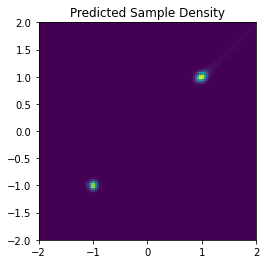

In [ ]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

plt.hist2d(samples_pred[:,0], samples_pred[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('Predicted Sample Density')
plt.show()